In [1]:
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import random
from tqdm import tqdm

%load_ext autoreload

In [10]:
%autoreload 2
from fpst import *

In [5]:
if "google.colab" in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    data_dir = os.path.join(root_dir, "data")
else:
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data")

dir = os.path.join(data_dir, "SPST_perfect")

In [6]:
file = loadmat(os.path.join(dir, "FPSTdata_2_pol-60.mat"))

fpsts_26 = file["fpsts"]
forbiden = file["forbiden"][0]
coords_26 = file["coords"]

In [11]:
dir_path = os.path.join(data_dir, "interpol_64", "FPST_3MI2_-60")
total_tasks = 512 * 512

fpsts_64, coords_64 = load_FPST(dir_path, total_tasks)

Overhead done, starting the loop


Process: 100%|██████████| 262144/262144 [04:30<00:00, 967.93task/s] 


In [26]:
from PIL import Image

fpsts_32 = np.empty((len(fpsts_26), 32, 32))
for i in range(len(fpsts_26)):
    #fpsts_32[i], _ = densify_to(fpsts_26[i], 32, None)
    # Interpolate the map to 32x32 using the nearest neighbour method
    fpsts_32[i] = np.array(Image.fromarray(fpsts_26[i]).resize((32, 32), resample=Image.NEAREST))

C:\Users\f076048\AppData\Local\Temp\ipykernel_16708\1995297373.py:8: RuntimeWarning: divide by zero encountered in log10
  fpst_64 = np.log10(np.abs(fpst_64))


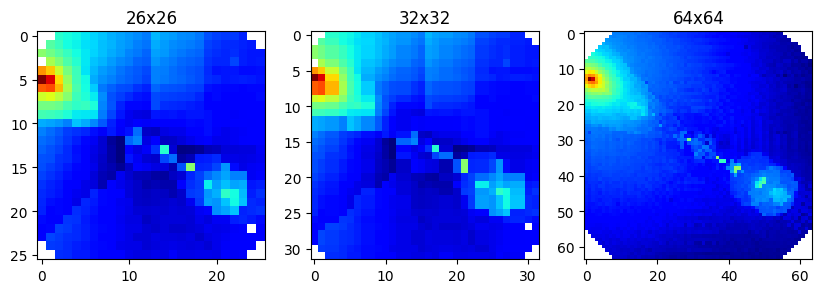

In [28]:
ind = random.randint(0, len(fpsts_64))
fpst_26 = fpsts_26[ind]
fps_32 = fpsts_32[ind]
fpst_64 = fpsts_64[ind]

fpst_26 = np.log10(np.abs(fpst_26))
fps_32 = np.log10(np.abs(fps_32))
fpst_64 = np.log10(np.abs(fpst_64))

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(fpst_26, cmap="jet")
axs[0].set_title("26x26")
axs[1].imshow(fps_32, cmap="jet")
axs[1].set_title("32x32")
axs[2].imshow(fpst_64, cmap="jet")
axs[2].set_title("64x64")
plt.show()

In [16]:
%autoreload 2
from classes.AE import Autoencoder

In [31]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split

In [29]:
# Create the autoencoder model
# 32x32x1 -> 64x64x1

ae = Sequential()

ae.add(Input(shape=(32, 32, 1)))

# Encoder (32x32x1 -> 16x16x8)
ae.add(Conv2D(8, (3, 3), activation="relu", padding="same"))
ae.add(MaxPooling2D((2, 2), padding="same"))

# (16x16x8 -> 8x8x16)
ae.add(Conv2D(16, (3, 3), activation="relu", padding="same"))
ae.add(MaxPooling2D((2, 2), padding="same"))

# Middle layer (8x8x16 -> 8x8x32)
ae.add(Conv2D(32, (3, 3), activation="relu", padding="same"))

# Decoder (8x8x32 -> 16x16x16)
ae.add(UpSampling2D((2, 2)))
ae.add(Conv2D(16, (3, 3), activation="relu", padding="same"))

# (16x16x16 -> 32x32x8)
ae.add(UpSampling2D((2, 2)))
ae.add(Conv2D(8, (3, 3), activation="relu", padding="same"))

# (32x32x8 -> 64x64x1)
ae.add(UpSampling2D((2, 2)))
ae.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

ae.compile(optimizer="adadelta", loss="mean_squared_error")

In [ ]:
ae.summary()

In [32]:
X = np.array(fpsts_32).reshape(-1, 32, 32, 1)
Y = np.array(fpsts_64).reshape(-1, 64, 64, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
ae.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))